In [3]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

from modelprocessing.functions import getBestModel
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import skops.io as sio

In [4]:
df = pd.read_pickle('/home/anuraaga/Documents/Projects/pricePredictor/dataset/dataset_car/autos_v3.pkl')

In [5]:
df

,name,abtest,vehicleType,yearOfRegistration,gearbox,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,price(inr)
0,Golf 3 16,test,Others,1993,Manual,150000,0,Petrol,Volkswagen,False,43200
1,Audi A5 Sportback,test,Coupe,2011,Manual,125000,5,Diesel,Audi,True,1647000
2,Jeep Grand Cherokee,test,Suv,2004,Automatic,125000,8,Diesel,Jeep,False,882000
3,GOLF 4 1,test,Compact,2001,Manual,150000,6,Petrol,Volkswagen,False,135000
4,Skoda Fabia 14,test,Compact,2008,Manual,90000,7,Diesel,Skoda,False,324000
...,...,...,...,...,...,...,...,...,...,...,...
360729,Sonstigeautos Suche t4,test,Others,2005,Manual,20000,1,Others,Sonstigeautos,False,198000
360730,Smart smart leistungssteigerung,test,Cabrio,2000,Automatic,125000,3,Petrol,Smart,False,107910
360731,Volkswagen Multivan T4,test,Bus,1996,Manual,150000,3,Diesel,Volkswagen,False,828000
360732,VW Golf Kombi,test,Combi,2002,Manual,150000,6,Diesel,Volkswagen,False,306000


In [6]:
df.isna().sum()

name                   0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
price(inr)             0
dtype: int64

In [7]:
df.drop('monthOfRegistration', axis=1, inplace=True)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
yearOfRegistration,360734.0,2.004563e+03,9.377812e+01,1000.0,1999.0,2003.0,2008.0,9.999000e+03
kilometer,360734.0,1.256093e+05,4.013812e+04,5000.0,125000.0,150000.0,150000.0,1.500000e+05
price(inr),360734.0,1.568993e+06,3.275229e+08,0.0,99990.0,265500.0,647910.0,1.932735e+11


In [9]:
df['price(inr)'].max() # noise

193273528230

In [10]:
df['yearOfRegistration'].max() # noise

9999

<Axes: ylabel='price(inr)'>

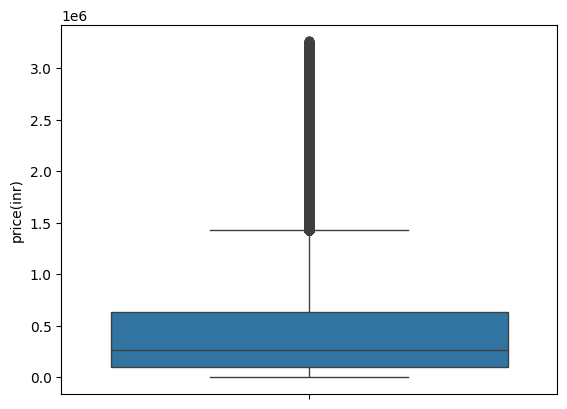

In [11]:
sns.boxplot(df[df['price(inr)']<=df['price(inr)'].quantile(0.99)]['price(inr)'])

In [12]:
df['price(inr)'] = np.where(df['price(inr)']> df['price(inr)'].quantile(0.99), df[df['price(inr)']<=df['price(inr)'].quantile(0.99)]['price(inr)'].max(), df['price(inr)'])

<Axes: ylabel='price(inr)'>

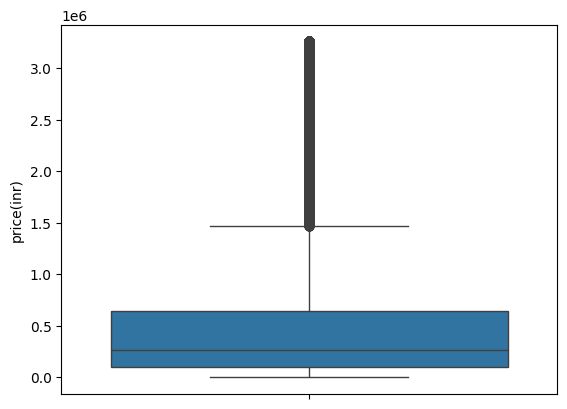

In [13]:
sns.boxplot(df['price(inr)'])

<Axes: ylabel='yearOfRegistration'>

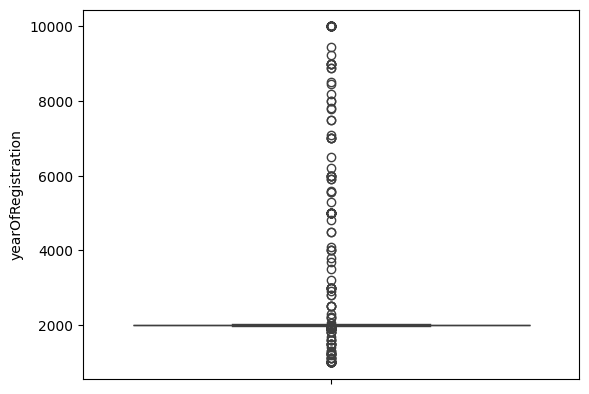

In [14]:
sns.boxplot(df['yearOfRegistration'])

too much noise values, replacing the noise values with the current year

In [15]:
data = df.copy()

In [16]:
data['yearOfRegistration'] = np.where(data['yearOfRegistration']>2023, 2023, data['yearOfRegistration'])

In [17]:
data['yearOfRegistration'] = np.where(data['yearOfRegistration']<1900, 1900, data['yearOfRegistration'])

<Axes: ylabel='yearOfRegistration'>

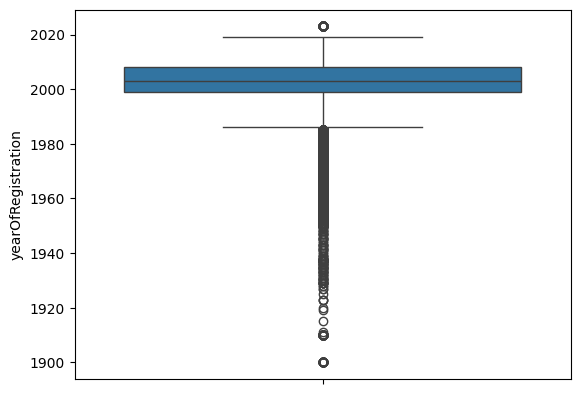

In [18]:
sns.boxplot(data['yearOfRegistration'])

In [19]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
yearOfRegistration,360734.0,2003.305136,7.942216,1900.0,1999.0,2003.0,2008.0,2023.0
kilometer,360734.0,125609.285512,40138.116479,5000.0,125000.0,150000.0,150000.0,150000.0
price(inr),360734.0,495665.829947,610039.518383,0.0,99990.0,265500.0,647910.0,3258000.0


In [20]:
data.drop('abtest', axis=1, inplace=True)

In [21]:
data['notRepairedDamage'] = data['notRepairedDamage'].replace({True:1, False:0})

In [22]:
data.to_csv('/home/anuraaga/Documents/Projects/pricePredictor/dataset/dataset_car/german_car.csv')

In [24]:
import pickle
pickle.dump(data, open('/home/anuraaga/Documents/Projects/pricePredictor/docker/german_car.pkl', 'wb'))

In [21]:
X = data.drop('price(inr)', axis=1)
y = data['price(inr)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
data.dtypes

name                  object
vehicleType           object
yearOfRegistration     int64
gearbox               object
kilometer              int64
fuelType              object
brand                 object
notRepairedDamage      int64
price(inr)             int64
dtype: object

In [23]:
ohe = OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32)
ohe.fit(X[['name', 'vehicleType', 'gearbox', 'fuelType', 'brand']])

OneHotEncoder(drop='first', dtype=<class 'numpy.int32'>, sparse_output=False)

In [24]:
column_transformer = make_column_transformer(
    (OneHotEncoder(categories=ohe.categories_), 
     ['name', 'vehicleType', 'gearbox', 'fuelType', 'brand']), remainder='passthrough')

In [25]:
# xg = XGBRegressor(booster= 'dart',
#                   learning_rate= 0.2,
#                   max_depth= 5,
#                   verbosity=0,
#                   tree_method='gpu_hist', 
#                   predictor='gpu_predictor', 
#                   device='cuda')
# pipe = make_pipeline(column_transformer, xg)
# pipe.fit(X_train, y_train)

In [26]:
pipe = sio.load('models/carmodel.skops', trusted=True)
# print(pipe.score(X_train, y_train), pipe.score(X_test, y_test))

/home/anuraaga/Documents/Projects/pricePredictor/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/anuraaga/Documents/Projects/pricePredictor/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/anuraaga/Documents/Projects/pricePredictor/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying 

In [27]:
X_train.columns

Index(['name', 'vehicleType', 'yearOfRegistration', 'gearbox', 'kilometer',
       'fuelType', 'brand', 'notRepairedDamage'],
      dtype='object')

In [28]:
X_test.head()

,name,vehicleType,yearOfRegistration,gearbox,kilometer,fuelType,brand,notRepairedDamage
311325,Mercedesbenz Mercedes Benz,Others,2017,Automatic,125000,Others,Mercedesbenz,0
109283,Golf Champ unfallfrei,Limousine,2002,Manual,150000,Diesel,Volkswagen,0
129930,Audi A3 Ambient,Compact,1997,Manual,150000,Petrol,Audi,0
99887,Audi A1 16,Compact,2011,Manual,150000,Diesel,Audi,0
326218,Alfa Spider 115,Cabrio,1989,Manual,125000,Petrol,Alfaromeo,0


In [29]:
pipe.predict(pd.DataFrame([['Alfa Spider 115', 'Compact', 1999, 'Manual', 150000, 'Petrol', 'Alfaromeo', False]], columns=X_test.columns))

array([63226.594], dtype=float32)

In [30]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.8100195495004294, 0.8039089277187783)

In [25]:
import pandas as pd
df = pd.read_pickle('/home/anuraaga/Documents/Projects/pricePredictor/docker/german_car.pkl')
df.head()

,name,vehicleType,yearOfRegistration,gearbox,kilometer,fuelType,brand,notRepairedDamage,price(inr)
0,Golf 3 16,Others,1993,Manual,150000,Petrol,Volkswagen,0,43200
1,Audi A5 Sportback,Coupe,2011,Manual,125000,Diesel,Audi,1,1647000
2,Jeep Grand Cherokee,Suv,2004,Automatic,125000,Diesel,Jeep,0,882000
3,GOLF 4 1,Compact,2001,Manual,150000,Petrol,Volkswagen,0,135000
4,Skoda Fabia 14,Compact,2008,Manual,90000,Diesel,Skoda,0,324000


In [26]:
df.isna().sum()

name                  0
vehicleType           0
yearOfRegistration    0
gearbox               0
kilometer             0
fuelType              0
brand                 0
notRepairedDamage     0
price(inr)            0
dtype: int64

In [27]:
df['brand'].unique()

array(['Volkswagen', 'Audi', 'Jeep', 'Skoda', 'Bmw', 'Peugeot', 'Ford',
       'Mazda', 'Nissan', 'Renault', 'Mercedesbenz', 'Opel', 'Seat',
       'Citroen', 'Honda', 'Fiat', 'Mini', 'Smart', 'Hyundai',
       'Sonstigeautos', 'Alfaromeo', 'Subaru', 'Volvo', 'Mitsubishi',
       'Kia', 'Suzuki', 'Lancia', 'Porsche', 'Toyota', 'Chevrolet',
       'Dacia', 'Daihatsu', 'Trabant', 'Saab', 'Chrysler', 'Jaguar',
       'Daewoo', 'Rover', 'Landrover', 'Lada'], dtype=object)

In [28]:
df[df['brand']==str('Bmw')]['name'].unique()

array(['BMW 316i e36', 'BMW 530i TV', 'BMW 530d touring', ...,
       'BMW E9 Coupe', 'BMW 320Diesel Automatik',
       'BMW M135i vollausgestattet'], dtype=object)

In [29]:
df.columns

Index(['name', 'vehicleType', 'yearOfRegistration', 'gearbox', 'kilometer',
       'fuelType', 'brand', 'notRepairedDamage', 'price(inr)'],
      dtype='object')